#Trabajo practico 3 Parte 3 Random Forest
Pinto, Nicolas \

##Imports

In [ ]:
import pandas as pd
import numpy as np

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import uniform

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SequentialFeatureSelector

##Datasets

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id= '1vAH4o97zYZ2RT8Mbgz3Be4AN2xxbA_4W'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_transaction.csv')
train_transaction = pd.read_csv('train_transaction.csv')

In [ ]:
id= '1YGDFxRvxm1wMVaL3E5GpgP2KQqun8OFj'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_identity.csv')
train_identity = pd.read_csv('train_identity.csv')

In [ ]:
joineado = pd.merge(left=train_transaction, right=train_identity, left_on='TransactionID', right_on='TransactionID', how = 'left')
del(train_transaction)
del(train_identity)

Para dividir el dataset es mejor hacerlo siguiendo un orden para evitar el time traveling, ya que no podemos agarrar datos al azar pues podriamos estar entrenando el modelo con datos que pasaron en el futuro y sacar conclusiones erroneas

In [ ]:
largo_train = int((joineado.shape[0])*0.8)
largo_validation = (joineado.shape[0]) - largo_train


In [ ]:
features_importantes = ['isFraud','V101','id_27','V232','V40','V79','V233','V18','V81','V52','M4','M2','V17','V103','V281','V33','V231','V80','V16','V15',
 'V34','V74','V39','V58','V51','V94','V93','V95','V85','DeviceType','C3','V73','V22','V43','V21','V27','V57','V28','V177','V92','V72','V60','V32','V31', 'V167',
 'V89','V84','V64','V59','V42','V63','V71','V219','id_15','id_37','card6','id_04', 'TransactionAmt','TransactionDT', 'C1', 'C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13',
 'C14','card1','card2','card3','card4','card5','addr1','addr2','P_emaildomain','R_emaildomain','dist1','dist2', 'DeviceInfo', 'id_31', 'id_33', 'id_12', 'id_16',
 'id_01', 'id_02', 'id_30', 'id_32', 'id_34','id_35','id_36','id_38', 'id_06','id_13','id_14','M3','M5','M6','M7','M8','M9', 'M1', 'id_28','id_29','id_11'] 

In [ ]:
joineado_reducido = joineado.loc[:, features_importantes].copy()

In [ ]:
train_set = joineado_reducido.iloc[:int((joineado.shape[0])*0.8)].copy()

In [ ]:
validation_set = joineado_reducido.iloc[largo_train:].copy()

In [ ]:
del(joineado)
del(joineado_reducido)

##Encoding

###Funciones auxiliares

In [ ]:
def llenar_nan_con_promedio(df, columna, promedios_numerica):
  promedio = df[columna].mean()
  promedios_numerica[columna] = promedio
  df[columna].fillna(promedio, inplace = True)

In [ ]:
def aplicar_mean_encoding(df, columna, promedios_por_columna):
    df[columna].fillna('Desconocido', inplace = True)
    dicc = df[columna].value_counts().to_dict()
    df['aux'] = df[columna].map(dicc)
    df.loc[df['aux']<500, columna]='Otro'
    mean_encoded = df.groupby([columna])['isFraud'].mean().to_dict()
    df[columna] = df[columna].map(mean_encoded)
    train_set.drop(['aux'], axis=1, inplace = True)
    promedios_por_columna[columna] = mean_encoded

In [ ]:
def aplicar_one_hot_encoding(df, columnas):
    return pd.get_dummies(df, dummy_na=True, drop_first=True, columns=columnas)   

###Encoding train set

In [ ]:
vectorizer = CountVectorizer(lowercase = True, max_features = 20)
train_set['id_31'].fillna('Desconocido', inplace = True)
matrix = vectorizer.fit_transform(train_set['id_31'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
for columna in df:
  train_set[columna] = df[columna]
del(df)

In [ ]:
promedios_por_columna = {}
for columna in train_set:
  if(train_set[columna].dtype==object):
    if(len(train_set[columna].value_counts()) > 5):
       aplicar_mean_encoding(train_set, columna, promedios_por_columna)

In [ ]:
columnas_one_hot = []
for columna in train_set:
  if(train_set[columna].dtype==object):
    columnas_one_hot.append(columna)
train_set = aplicar_one_hot_encoding(train_set, columnas_one_hot)

In [ ]:
promedios_numerica = {}
llenar_nan_con_promedio(train_set, 'card1', promedios_numerica)
for columna in train_set:
  if(train_set[columna].dtype == float):
    llenar_nan_con_promedio(train_set, columna, promedios_numerica)

In [ ]:
train_set['TransactionDT']= train_set['TransactionDT'] % 86400

###Encoding validation set

In [ ]:
validation_set['id_31'].fillna('Desconocido', inplace = True)
matrix = vectorizer.transform(validation_set['id_31'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
validation_set.reset_index(inplace = True, drop = True)
for columna in df:
  validation_set[columna] = df[columna]
del(df)

In [ ]:
for columna in promedios_por_columna:
   promedios_numerica[columna] = promedios_por_columna[columna]['Desconocido']
   validation_set[columna] = validation_set[columna].map(promedios_por_columna)

In [ ]:
for columna in promedios_numerica:
  validation_set[columna].fillna(promedios_numerica[columna], inplace = True)

In [ ]:
validation_set = aplicar_one_hot_encoding(validation_set, columnas_one_hot)

In [ ]:
validation_set['TransactionDT']= validation_set['TransactionDT'] % 86400

##Divido los datasets

In [ ]:
y_train = train_set['isFraud'].copy()
train_set.drop(columns=['isFraud'],inplace=True)
x_train = train_set

In [ ]:
y_validation = validation_set['isFraud'].copy()
validation_set.drop(columns=['isFraud'],inplace=True)
x_validation = validation_set

In [ ]:
for columna in train_set:
  if columna not in validation_set:
    validation_set[columna] = 0

In [ ]:
x_validation = x_validation.reindex(columns=x_train.columns)

##Random forest

###Training

In [ ]:
modelo = RandomForestClassifier(random_state=1)

In [ ]:
params = {'bootstrap': [True, False],
               'max_depth': [30, 50, 70, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = modelo, param_distributions = params, n_iter = 7, scoring = 'roc_auc', cv = 4, verbose=100, random_state=1, n_jobs = 1)

In [ ]:
rf_random.fit(x_train.values, y_train.values)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4; 1/7] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180
[CV 1/4; 1/7] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180;, score=0.881 total time= 3.0min
[CV 2/4; 1/7] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180
[CV 2/4; 1/7] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180;, score=0.919 total time= 3.4min
[CV 3/4; 1/7] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180
[CV 3/4; 1/7] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=180;, score=0.911 total time= 3.3min
[CV 4/4; 1/7] START bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=1),
                   n_iter=7, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [30, 50, 70, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=1, scoring='roc_auc', verbose=100)

In [ ]:
#import pickle
#with open('model_backup', 'wb') as model_backup_file:
#  pickle.dump(rf_random, model_backup_file)

In [ ]:
#import pickle 
#with open('model_backup', 'rb') as file:
#  rf_random = pickle.load(file)

###Validation

In [ ]:
roc_auc_score(y_validation.values, rf_random.predict_proba(x_validation.values)[:,1])

0.8982119656313754

In [ ]:
print(classification_report(y_validation.values, rf_random.predict(x_validation.values)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    114044
           1       0.86      0.22      0.35      4064

    accuracy                           0.97    118108
   macro avg       0.92      0.61      0.67    118108
weighted avg       0.97      0.97      0.96    118108



###Test

####Datasets

In [ ]:
id= '16HGAtDL8NdWSnqE-5WThosY2q0QIoeX-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

In [ ]:
id= '1w-hO21eHxYs8NgW_NhXZpckfGuQEL22j'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [ ]:
test_set = pd.merge(left=test_transaction, right=test_identity, left_on='TransactionID', right_on='TransactionID', how = 'left')
del(test_transaction)
del(test_identity)

In [ ]:
test_set.shape[0]

506691

In [ ]:
transaction_id = test_set['TransactionID']

In [ ]:
for columnas in test_set:
  test_set.rename(columns=lambda x: x.replace('id-', 'id_'), inplace = True)

In [ ]:
features_importantes_test = ['V101','id_27','V232','V40','V79','V233','V18','V81','V52','M4','M2','V17','V103','V281','V33','V231','V80','V16','V15',
 'V34','V74','V39','V58','V51','V94','V93','V95','V85','DeviceType','C3','V73','V22','V43','V21','V27','V57','V28','V177','V92','V72','V60','V32','V31','V167',
 'V89','V84','V64','V59','V42','V63','V71','V219','id_15','id_37','card6','id_04', 'TransactionAmt','TransactionDT', 'C1', 'C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13',
 'C14','card1','card2','card3','card4','card5','addr1','addr2','P_emaildomain','R_emaildomain','dist1','dist2', 'DeviceInfo', 'id_31', 'id_33', 'id_12', 'id_16',
 'id_01', 'id_02', 'id_30', 'id_32', 'id_34','id_35','id_36','id_38', 'id_06','id_13','id_14','M3','M5','M6','M7','M8','M9', 'M1', 'id_28','id_29','id_11'] 

In [ ]:
test_set = test_set.loc[:, features_importantes_test]

####Encoding

In [ ]:
test_set['TransactionDT']= test_set['TransactionDT'] % 86400

In [ ]:
test_set['id_31'].fillna('Desconocido', inplace = True)
matrix = vectorizer.transform(test_set['id_31'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
test_set.reset_index(inplace = True, drop = True)
for columna in df:
  test_set[columna] = df[columna]
del(df)

In [ ]:
test_set = aplicar_one_hot_encoding(test_set, columnas_one_hot)

In [ ]:
for columna in promedios_por_columna:
   test_set[columna] = test_set[columna].map(promedios_por_columna)

In [ ]:
for columna in promedios_numerica:
  test_set[columna].fillna(promedios_numerica[columna], inplace = True)

In [ ]:
for columna in train_set:
  if columna not in test_set:
    test_set[columna] = 0

In [ ]:
test_set = test_set.reindex(columns=x_train.columns)

####Predicciones

In [ ]:
rf_random.predict_proba(test_set.values)[:,1]

array([0.01841824, 0.03566089, 0.07055543, ..., 0.01084929, 0.01994674,
       0.02762346])

##Score de la competencia

In [ ]:
predicciones_fraude_random_forest = pd.DataFrame()
predicciones_fraude_random_forest['isFraud'] = rf_random.predict_proba(test_set.values)[:,1]
predicciones_fraude_random_forest['TransactionID']= transaction_id.values
predicciones_fraude_random_forest.to_csv('predicciones_fraude_random_forest.csv', index=False)

<img src= "https://drive.google.com/uc?id=11hNMx06kP899a0a9brX4w3amqtD8rZch" width="100%">



##Matriz de confusion

In [ ]:
predicciones = rf_random.predict(x_validation.values)
target_real = y_validation


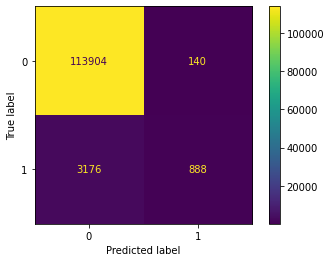

In [ ]:
matrix = confusion_matrix(target_real, predicciones)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()